# Preprocessing SODA and Training GNNs and CNNs

(Simplified, without Comments)

by Ding

For exploratory steps and comments, please see [this notebook](https://github.com/ding05/GNN_CNN_MHW_Forecasting_EEs/blob/main/preprocessing_c.ipynb).

In [94]:
!pip install geopandas

import numpy as np
from netCDF4 import Dataset
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

In [95]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [96]:
%%bash
cp -a "/gdrive/MyDrive/soda_331_pt_l5.nc" "/content/"
#cp -a "/gdrive/MyDrive/sst_anomaly.nc" "/content/"

In [97]:
soda = xr.open_dataset("soda_331_pt_l5.nc", decode_times=False)
soda

<xarray.Dataset>
Dimensions:    (depth: 1, latitude: 330, longitude: 720, time: 432)
Coordinates:
  * time       (time) float64 3.168e+08 3.195e+08 ... 1.448e+09 1.45e+09
  * depth      (depth) float32 5.034
  * latitude   (latitude) float32 -74.75 -74.25 -73.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float32 0.25 0.75 1.25 1.75 ... 358.8 359.2 359.8
Data variables:
    temp       (time, depth, latitude, longitude) float32 ...
Attributes: (12/47)
    _CoordSysBuilder:              ucar.nc2.internal.dataset.conv.DefaultConv...
    acknowledgement:               The SODA3 project is funded by the US Nati...
    cdm_data_type:                 Grid
    Conventions:                   COARDS, CF-1.6, ACDD-1.3
    Created_by:                    Gennady Chepurin and Ligang Chen
    creation_date:                 October, 2016
    ...                            ...
    summary:                       SODA3.3.1 ocean state, forced by MERRA2. T...
    time_coverage_end:             2015-12-16T00:00:00Z
    time_coverage_start:           1980-01-16T00:00:00Z
    title:                         SODA 3.3.1 Ocean State, 1/2°, Global, 1980...
    Website:                       https://www.atmos.umd.edu/~ocean/
    Westernmost_Easting:           0.25

In [98]:
soda_array = soda.to_array(dim="temp")
soda_smaller = soda_array[:,:,:,::5,::5].to_dataset(dim="temp")
soda_smaller

<xarray.Dataset>
Dimensions:    (depth: 1, latitude: 66, longitude: 144, time: 432)
Coordinates:
  * time       (time) float64 3.168e+08 3.195e+08 ... 1.448e+09 1.45e+09
  * depth      (depth) float32 5.034
  * latitude   (latitude) float32 -74.75 -72.25 -69.75 ... 82.75 85.25 87.75
  * longitude  (longitude) float32 0.25 2.75 5.25 7.75 ... 352.8 355.2 357.8
Data variables:
    temp       (time, depth, latitude, longitude) float32 nan nan ... -1.636
Attributes: (12/47)
    _CoordSysBuilder:              ucar.nc2.internal.dataset.conv.DefaultConv...
    acknowledgement:               The SODA3 project is funded by the US Nati...
    cdm_data_type:                 Grid
    Conventions:                   COARDS, CF-1.6, ACDD-1.3
    Created_by:                    Gennady Chepurin and Ligang Chen
    creation_date:                 October, 2016
    ...                            ...
    summary:                       SODA3.3.1 ocean state, forced by MERRA2. T...
    time_coverage_end:             2015-12-16T00:00:00Z
    time_coverage_start:           1980-01-16T00:00:00Z
    title:                         SODA 3.3.1 Ocean State, 1/2°, Global, 1980...
    Website:                       https://www.atmos.umd.edu/~ocean/
    Westernmost_Easting:           0.25

In [99]:
start_year = 1980
end_year = 2016

In [100]:
start_month = (start_year - 1980) * 12
end_month = (end_year - 1980) * 12

soda_sst = np.zeros((end_month-start_month,1,66,144))
soda_sst[:,:,:,:] = soda_smaller.variables["temp"][0:end_month-start_month,:,:,:]

In [101]:
soda_sst = np.squeeze(soda_sst, axis=1)

soda_sst_list = soda_sst.tolist()

months = list(range(0, 432))
monthly_average_all = []

for i in range(12):
  individual_month = months[i + start_month : end_month : 12]
  average = np.zeros((66,144))
  for j in range(len(individual_month)):
    average += soda_sst[individual_month[j]]
    # average_map += np.array(individual_month[j])
  monthly_average = average / len(individual_month)
  monthly_average_all.append(monthly_average)
  print("Month " + str(i+1) + " is appended.")

Month 1 is appended.
Month 2 is appended.
Month 3 is appended.
Month 4 is appended.
Month 5 is appended.
Month 6 is appended.
Month 7 is appended.
Month 8 is appended.
Month 9 is appended.
Month 10 is appended.
Month 11 is appended.
Month 12 is appended.


In [102]:
monthly_average_all_432 = []
monthly_average_all_432 = monthly_average_all
print(len(monthly_average_all))
print(len(monthly_average_all_432))

for i in range(432 - 12):
  monthly_average_all_432.append(monthly_average_all_432[i])

print(len(monthly_average_all_432))

soda_sst_anomaly_list = []

for i in range(432):
  soda_sst_anomaly_list.append(soda_sst[i] - monthly_average_all_432[i])

12
12
432


In [103]:
soda_sst_anomaly = np.array(soda_sst_anomaly_list)

soda_sst_anomaly.shape

(432, 66, 144)

--------

In [104]:
soda_smaller_bop = soda_smaller.loc[dict(latitude="-34.75", longitude="177.75")]

soda_sst_bop = np.zeros((end_month-start_month,1))
soda_sst_bop[:,:] = soda_smaller_bop.variables["temp"][:,:]

print(soda_sst_bop)

[[20.99832344]
 [21.79081154]
 [20.60656357]
 [19.01729202]
 [18.35627174]
 [16.8011055 ]
 [14.99956512]
 [14.56353569]
 [15.07971001]
 [16.14177513]
 [17.45836639]
 [19.13077354]
 [21.79137993]
 [22.22587204]
 [21.55210495]
 [20.73086357]
 [18.87947655]
 [17.26327705]
 [16.5136528 ]
 [16.17926979]
 [16.01082802]
 [16.73580742]
 [17.0369873 ]
 [19.68212128]
 [21.40428734]
 [20.97167206]
 [20.92926979]
 [19.90824127]
 [17.99365234]
 [16.92311478]
 [16.46268654]
 [15.89421272]
 [15.79411983]
 [16.05239105]
 [17.40579796]
 [19.19625282]
 [20.42951202]
 [20.65821838]
 [21.26511574]
 [20.50668907]
 [18.65052605]
 [17.1424675 ]
 [16.40631485]
 [15.7081995 ]
 [15.72676659]
 [16.41251564]
 [17.5380764 ]
 [18.53281021]
 [20.26769066]
 [20.86043739]
 [21.16428566]
 [20.81809425]
 [18.97973442]
 [17.78092384]
 [17.29343987]
 [16.34168816]
 [16.67136383]
 [16.80033302]
 [18.7995739 ]
 [20.84270287]
 [22.26089287]
 [21.45246315]
 [21.21871948]
 [19.94374466]
 [18.96822929]
 [17.32666588]
 [16.92034

In [105]:
soda_sst_bop

array([[20.99832344],
       [21.79081154],
       [20.60656357],
       [19.01729202],
       [18.35627174],
       [16.8011055 ],
       [14.99956512],
       [14.56353569],
       [15.07971001],
       [16.14177513],
       [17.45836639],
       [19.13077354],
       [21.79137993],
       [22.22587204],
       [21.55210495],
       [20.73086357],
       [18.87947655],
       [17.26327705],
       [16.5136528 ],
       [16.17926979],
       [16.01082802],
       [16.73580742],
       [17.0369873 ],
       [19.68212128],
       [21.40428734],
       [20.97167206],
       [20.92926979],
       [19.90824127],
       [17.99365234],
       [16.92311478],
       [16.46268654],
       [15.89421272],
       [15.79411983],
       [16.05239105],
       [17.40579796],
       [19.19625282],
       [20.42951202],
       [20.65821838],
       [21.26511574],
       [20.50668907],
       [18.65052605],
       [17.1424675 ],
       [16.40631485],
       [15.7081995 ],
       [15.72676659],
       [16

In [106]:
soda_sst_bop = np.squeeze(soda_sst_bop)

In [107]:
soda_sst_bop_monthly_average = []

for i in range(12):
  monthly_sst_anomaly = soda_sst_bop[i:336:12] # Use the first 28 years (training set) to compute SSTAs.
  #print(len(monthly_sst_anomaly))
  soda_sst_bop_monthly_average.append(sum(monthly_sst_anomaly)/len(monthly_sst_anomaly))

soda_sst_bop_anomaly = []

for i in range(len(soda_sst_bop)):
  j = i % 12
  soda_sst_bop_anomaly.append(soda_sst_bop[i] - soda_sst_bop_monthly_average[j])

In [108]:
soda_sst_bop_anomaly

[-0.07720347813197392,
 0.2201742444719592,
 -0.4943958691188257,
 -1.13429389681135,
 -0.514451163155691,
 -0.6640091964176733,
 -1.4980301175798694,
 -1.380144289561681,
 -0.8549330915723523,
 -0.4268078463418128,
 -0.27630468777247685,
 -0.34597798756190556,
 0.7158530099051355,
 0.655234745570592,
 0.4511455127171118,
 0.579277651650564,
 0.008753640311105926,
 -0.20183764185224362,
 0.016057559422083756,
 0.23558981078011598,
 0.07618491990225706,
 0.16722444125584346,
 -0.6976837771279456,
 0.20536974498203975,
 0.3287604195731042,
 -0.5989652361188611,
 -0.17168964658464603,
 -0.24334464754377194,
 -0.877070563180105,
 -0.5419999190739233,
 -0.03490870339529906,
 -0.04946725709097777,
 -0.14052326338631715,
 -0.516191925321305,
 -0.32887312344142217,
 -0.28049870899745244,
 -0.6460148947579505,
 -0.9124189104352673,
 0.16415630068097897,
 0.35510315213884525,
 -0.22019686017717532,
 -0.32264719690595456,
 -0.0912803922380725,
 -0.23548047883170042,
 -0.20787651198250856,
 -0.156

In [109]:
soda_sst_bop_anomaly = np.array(soda_sst_bop_anomaly)

In [110]:
np.round(soda_sst_bop_anomaly, decimals=2)

array([-0.08,  0.22, -0.49, -1.13, -0.51, -0.66, -1.5 , -1.38, -0.85,
       -0.43, -0.28, -0.35,  0.72,  0.66,  0.45,  0.58,  0.01, -0.2 ,
        0.02,  0.24,  0.08,  0.17, -0.7 ,  0.21,  0.33, -0.6 , -0.17,
       -0.24, -0.88, -0.54, -0.03, -0.05, -0.14, -0.52, -0.33, -0.28,
       -0.65, -0.91,  0.16,  0.36, -0.22, -0.32, -0.09, -0.24, -0.21,
       -0.16, -0.2 , -0.94, -0.81, -0.71,  0.06,  0.67,  0.11,  0.32,
        0.8 ,  0.4 ,  0.74,  0.23,  1.06,  1.37,  1.19, -0.12,  0.12,
       -0.21,  0.1 , -0.14,  0.42,  0.46,  0.24,  0.33, -0.17, -0.12,
        0.69,  0.32,  0.53,  0.22,  0.26, -0.15, -0.34, -0.29, -0.25,
        0.08, -0.22, -0.75, -0.68, -0.12, -0.37, -0.73, -0.45,  0.2 ,
        0.36,  0.43,  0.29,  0.36,  0.3 ,  0.29, -0.12,  0.84,  0.6 ,
        0.07,  0.19,  0.79,  0.89,  0.57,  0.7 ,  0.72,  0.53,  1.2 ,
        0.73, -0.2 ,  0.02,  0.11,  0.59,  0.46,  0.64,  0.67,  0.65,
        0.47,  0.82,  0.12,  0.42,  1.01,  1.29,  0.57,  0.39,  0.13,
       -0.11,  0.21,

------------------

In [111]:
soda_sst_anomaly_transposed = soda_sst_anomaly.transpose(1,2,0)
soda_sst_anomaly_flattened = soda_sst_anomaly_transposed.reshape(soda_sst_anomaly.shape[1] * soda_sst_anomaly.shape[2],432)
soda_sst_anomaly_flattened.shape

(9504, 432)

In [112]:
def dropna(arr, *args, **kwarg):
    assert isinstance(arr, np.ndarray)
    dropped=pd.DataFrame(arr).dropna(*args, **kwarg).values
    if arr.ndim==1:
        dropped=dropped.flatten()
    return dropped

soda_sst_anomaly_ocean_flattened = dropna(soda_sst_anomaly_flattened)
soda_sst_anomaly_ocean_flattened.shape

(6924, 432)

In [113]:
feature_matrix = soda_sst_anomaly_ocean_flattened

In [114]:
lons, lats = np.meshgrid(soda_smaller.longitude.values, soda_smaller.latitude.values)

soda_time_1 = soda_smaller.temp.isel(depth=0,time=240)

soda_time_1_lons, soda_time_1_lats = np.meshgrid(soda_time_1.longitude.values, soda_time_1.latitude.values)

soda_masked = soda_time_1.where(abs(soda_time_1_lons) + abs(soda_time_1_lats) > 0)
soda_masked

<xarray.DataArray 'temp' (latitude: 66, longitude: 144)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [-1.1247305, -1.4289024, -1.4716144, ..., -1.7336361, -1.7187185,
        -1.6495545],
       ...,
       [-1.7470648, -1.7409257, -1.7132384, ..., -1.7103977, -1.7174913,
        -1.7176341],
       [-1.7337334, -1.7335713, -1.740988 , ..., -1.7035117, -1.7163125,
        -1.7244432],
       [-1.7108924, -1.7107269, -1.7117507, ..., -1.7120712, -1.7136484,
        -1.7127907]], dtype=float32)
Coordinates:
    time       float64 9.48e+08
    depth      float32 5.034
  * latitude   (latitude) float32 -74.75 -72.25 -69.75 ... 82.75 85.25 87.75
  * longitude  (longitude) float32 0.25 2.75 5.25 7.75 ... 352.8 355.2 357.8

In [115]:
soda_masked.values.flatten()[soda_masked.notnull().values.flatten()]

len(soda_masked.values.flatten()[soda_masked.notnull().values.flatten()])

6924

In [116]:
print(soda_time_1_lons.flatten()[soda_masked.notnull().values.flatten()])
print(soda_time_1_lats.flatten()[soda_masked.notnull().values.flatten()])

[162.75 165.25 167.75 ... 352.75 355.25 357.75]
[-74.75 -74.75 -74.75 ...  87.75  87.75  87.75]


In [117]:
from sklearn.metrics.pairwise import haversine_distances

lons_ocean = soda_time_1_lons.flatten()[soda_masked.notnull().values.flatten()]
lons_ocean = lons_ocean[::]

lats_ocean = soda_time_1_lats.flatten()[soda_masked.notnull().values.flatten()]
lats_ocean = lats_ocean[::]

lons_ocean *= np.pi/180
lats_ocean *= np.pi/180

points_ocean = np.concatenate([np.expand_dims(lats_ocean.flatten(),-1), np.expand_dims(lons_ocean.flatten(),-1)],-1)

distance_ocean = 6371*haversine_distances(points_ocean)

In [118]:
distance_ocean_diag = distance_ocean
distance_ocean_diag[distance_ocean_diag==0] = 1

distance_ocean_recip = np.reciprocal(distance_ocean_diag)

distance_ocean_recip.shape

(6924, 6924)

In [119]:
adjacency_matrix = distance_ocean_recip

In [120]:
lead_month = 0

feature_matrix = feature_matrix[:,:len(feature_matrix[0])-lead_month:]
adjacency_matrix = adjacency_matrix

In [121]:
import os
import json
import math
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("svg", "pdf") # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams["lines.linewidth"] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [122]:
node_feats = torch.tensor(np.expand_dims(feature_matrix, axis=0)).float()
adj_matrix = torch.tensor(np.expand_dims(adjacency_matrix, axis=0)).float()

print(node_feats.shape)
print(adj_matrix.shape)

torch.Size([1, 6924, 432])
torch.Size([1, 6924, 6924])


In [123]:
class GCNLayer(nn.Module):

    def __init__(self, c_in, c_out):
        super().__init__()
        self.projection = nn.Linear(c_in, c_out)

    def forward(self, node_feats, adj_matrix):
        """
        Inputs:
            node_feats - Tensor with node features of shape [batch_size, num_nodes, c_in]
            adj_matrix - Batch of adjacency matrices of the graph. If there is an edge from i to j, adj_matrix[b,i,j]=1 else 0.
                         Supports directed edges by non-symmetric matrices. Assumes to already have added the identity connections.
                         Shape: [batch_size, num_nodes, num_nodes]
        """
        # Num neighbours = number of incoming edges
        num_neighbours = adj_matrix.sum(dim=-1, keepdims=True)
        node_feats = self.projection(node_feats)
        node_feats = torch.bmm(adj_matrix, node_feats)
        node_feats = node_feats / num_neighbours
        return node_feats

In [124]:
print("Node features:\n", node_feats)
print("\nAdjacency matrix:\n", adj_matrix)

Node features:
 tensor([[[-7.9552e-02, -7.8261e-02,  4.1625e-02,  ..., -3.3746e-03,
           8.1046e-03, -4.8462e-02],
         [ 1.1985e+00,  3.5482e-01,  1.2477e-01,  ..., -1.4804e-02,
          -9.4055e-03, -1.1167e-01],
         [ 1.7171e+00,  1.1768e+00,  1.3464e-01,  ..., -1.2377e-04,
           1.9625e-03, -8.1020e-02],
         ...,
         [-9.9387e-02, -9.5504e-02, -9.8592e-02,  ...,  8.6997e-02,
           6.8804e-02,  6.4023e-02],
         [-1.0047e-01, -9.3609e-02, -9.5575e-02,  ...,  8.7748e-02,
           7.1659e-02,  6.7239e-02],
         [-9.4762e-02, -8.9556e-02, -9.3895e-02,  ...,  8.8551e-02,
           7.4358e-02,  7.0678e-02]]])

Adjacency matrix:
 tensor([[[1.0000e+00, 1.3677e-02, 6.8402e-03,  ..., 5.3864e-05,
          5.3872e-05, 5.3880e-05],
         [1.3677e-02, 1.0000e+00, 1.3677e-02,  ..., 5.3859e-05,
          5.3864e-05, 5.3872e-05],
         [6.8402e-03, 1.3677e-02, 1.0000e+00,  ..., 5.3855e-05,
          5.3859e-05, 5.3864e-05],
         ...,
       

In [125]:
temp_list = []
for i in range(0, feature_matrix.shape[1]):
  element = [0] * feature_matrix.shape[1]
  element[i] = 1
  element = [float(item) for item in element] # Convert the type into float.
  temp_list.append(element)

layer = GCNLayer(c_in=feature_matrix.shape[1], c_out=feature_matrix.shape[1])
layer.projection.weight.data = torch.tensor(temp_list)

layer.projection.bias.data = torch.Tensor([0] * feature_matrix.shape[1])

In [126]:
with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix)

print("Adjacency matrix")
print(np.round(np.array(adj_matrix), decimals=3))
print("Input features")
print(np.round(np.array(node_feats), decimals=3))
print("Output features")
print(np.round(np.array(out_feats), decimals=3))

Adjacency matrix
[[[1.    0.014 0.007 ... 0.    0.    0.   ]
  [0.014 1.    0.014 ... 0.    0.    0.   ]
  [0.007 0.014 1.    ... 0.    0.    0.   ]
  ...
  [0.    0.    0.    ... 1.    0.092 0.046]
  [0.    0.    0.    ... 0.092 1.    0.092]
  [0.    0.    0.    ... 0.046 0.092 1.   ]]]
Input features
[[[-0.08  -0.078  0.042 ... -0.003  0.008 -0.048]
  [ 1.198  0.355  0.125 ... -0.015 -0.009 -0.112]
  [ 1.717  1.177  0.135 ... -0.     0.002 -0.081]
  ...
  [-0.099 -0.096 -0.099 ...  0.087  0.069  0.064]
  [-0.1   -0.094 -0.096 ...  0.088  0.072  0.067]
  [-0.095 -0.09  -0.094 ...  0.089  0.074  0.071]]]
Output features
[[[ 0.296  0.161  0.13  ...  0.097  0.094  0.011]
  [ 0.9    0.37   0.17  ...  0.091  0.085 -0.019]
  [ 1.143  0.759  0.176 ...  0.097  0.09  -0.006]
  ...
  [-0.085 -0.065 -0.066 ...  0.17   0.134  0.142]
  [-0.085 -0.065 -0.065 ...  0.17   0.135  0.143]
  [-0.084 -0.064 -0.065 ...  0.171  0.136  0.144]]]


In [127]:
print(soda_time_1_lons.flatten()[soda_masked.notnull().values.flatten()])
print(soda_time_1_lats.flatten()[soda_masked.notnull().values.flatten()])

lons_smaller = soda_time_1_lons.flatten()[soda_masked.notnull().values.flatten()]
lats_smaller = soda_time_1_lats.flatten()[soda_masked.notnull().values.flatten()]

for i in range(len(lats_smaller)):
  if lats_smaller[i] > -39 and lats_smaller[i] < -34:
    print("The position: ", str(i), "; the latitude: ", str(lats_smaller[i]), "; the longitude: ", str(lons_smaller[i]))

[162.75 165.25 167.75 ... 352.75 355.25 357.75]
[-74.75 -74.75 -74.75 ...  87.75  87.75  87.75]
The position:  1880 ; the latitude:  -37.25 ; the longitude:  0.25
The position:  1881 ; the latitude:  -37.25 ; the longitude:  2.75
The position:  1882 ; the latitude:  -37.25 ; the longitude:  5.25
The position:  1883 ; the latitude:  -37.25 ; the longitude:  7.75
The position:  1884 ; the latitude:  -37.25 ; the longitude:  10.25
The position:  1885 ; the latitude:  -37.25 ; the longitude:  12.75
The position:  1886 ; the latitude:  -37.25 ; the longitude:  15.25
The position:  1887 ; the latitude:  -37.25 ; the longitude:  17.75
The position:  1888 ; the latitude:  -37.25 ; the longitude:  20.25
The position:  1889 ; the latitude:  -37.25 ; the longitude:  22.75
The position:  1890 ; the latitude:  -37.25 ; the longitude:  25.25
The position:  1891 ; the latitude:  -37.25 ; the longitude:  27.75
The position:  1892 ; the latitude:  -37.25 ; the longitude:  30.25
The position:  1893 ; th

In [128]:
print("The position: 2079; the latitude: -34.75; the longitude: 177.75, which one point in Bay of Plenty")

The position: 2079; the latitude: -34.75; the longitude: 177.75, which one point in Bay of Plenty


In [129]:
gnn_output = np.round(np.array(out_feats), decimals=2)
gnn_input = np.round(np.array(node_feats), decimals=2)

In [130]:
gnn_output_bop = gnn_output[0][2079]
gnn_input_bop = gnn_input[0][2079]

In [131]:
from sklearn.metrics import mean_squared_error

gnn_mse_bop = mean_squared_error(gnn_output_bop, gnn_input_bop)
print(gnn_mse_bop)

0.08179954


------------------

In [132]:
soda_sst_anomaly.shape

(432, 66, 144)

In [133]:
gnn_input_bop

array([-0.15,  0.17, -0.49, -1.13, -0.54, -0.69, -1.48, -1.35, -0.81,
       -0.41, -0.27, -0.43,  0.64,  0.6 ,  0.45,  0.58, -0.02, -0.23,
        0.03,  0.27,  0.12,  0.18, -0.69,  0.12,  0.26, -0.65, -0.17,
       -0.24, -0.9 , -0.57, -0.02, -0.02, -0.1 , -0.5 , -0.32, -0.36,
       -0.72, -0.97,  0.17,  0.36, -0.25, -0.35, -0.07, -0.2 , -0.17,
       -0.14, -0.19, -1.02, -0.88, -0.76,  0.07,  0.67,  0.08,  0.28,
        0.81,  0.43,  0.78,  0.25,  1.07,  1.29,  1.11, -0.17,  0.12,
       -0.21,  0.07, -0.17,  0.44,  0.49,  0.28,  0.35, -0.16, -0.2 ,
        0.62,  0.27,  0.53,  0.23,  0.24, -0.18, -0.32, -0.25, -0.2 ,
        0.1 , -0.21, -0.83, -0.75, -0.17, -0.37, -0.73, -0.47,  0.16,
        0.38,  0.46,  0.34,  0.37,  0.31,  0.21, -0.2 ,  0.78,  0.6 ,
        0.07,  0.16,  0.76,  0.9 ,  0.6 ,  0.74,  0.74,  0.53,  1.12,
        0.65, -0.25,  0.02,  0.11,  0.56,  0.43,  0.66,  0.7 ,  0.7 ,
        0.49,  0.83,  0.03,  0.35,  0.96,  1.29,  0.58,  0.36,  0.1 ,
       -0.09,  0.24,

In [134]:
soda_sst_anomaly.shape

soda_sst_anomaly = np.nan_to_num(soda_sst_anomaly, nan=0)

soda_sst_anomaly_CNN = np.expand_dims(soda_sst_anomaly, axis=1)

print(soda_sst_anomaly_CNN.shape)
print(soda_sst_bop_anomaly.shape)

(432, 1, 66, 144)
(432,)


In [135]:
train_data = []

for i in range(len(soda_sst_anomaly_CNN)):
  train_data.append((soda_sst_anomaly_CNN[i], soda_sst_bop_anomaly[i]))

In [136]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as Data
from torch.autograd import Variable

EPOCH = 10
BATCH_SIZE = len(soda_sst_anomaly_CNN) # 8, 16, 32, 64, ...
LR = 0.00001

train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)
train_all_loader = Data.DataLoader(dataset=train_data, batch_size=len(train_data), shuffle=False)

In [137]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 16, 3, 1, 1),
            nn.Tanh(),
        )
        self.out = nn.Linear(38016, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x

cnn = CNN().double()

print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
  )
  (out): Linear(in_features=38016, out_features=1, bias=True)
)


In [138]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
loss_func = nn.MSELoss() 

In [139]:
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)
        b_y = Variable(y)

        output = cnn(b_x)[0]
        output = output.reshape(-1) # To avoid different sizes
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for step, (x, y) in enumerate(train_all_loader):
        c_x = Variable(x)
        c_y = Variable(y)

    #for step, (x, y) in enumerate(test_loader):
        #d_x = Variable(x)
        #d_y = Variable(y)

        if step % 100 == 0:
            
            pred_train_y, last_layer = cnn(c_x)
            train_mse = loss_func(pred_train_y, c_y)

            #pred_test_y, last_layer = cnn(d_x)
            #test_mse = loss_func(pred_test_y, d_y)

            print("Epoch:", epoch, "| trainig loss: %.4f" % loss.data, "| training MSE: %.4f" % train_mse)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([432])) that is different to the input size (torch.Size([432, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 | trainig loss: 0.3761 | training MSE: 0.3821
Epoch: 1 | trainig loss: 0.3680 | training MSE: 0.3801
Epoch: 2 | trainig loss: 0.3621 | training MSE: 0.3800
Epoch: 3 | trainig loss: 0.3576 | training MSE: 0.3808
Epoch: 4 | trainig loss: 0.3538 | training MSE: 0.3818
Epoch: 5 | trainig loss: 0.3500 | training MSE: 0.3826
Epoch: 6 | trainig loss: 0.3460 | training MSE: 0.3833
Epoch: 7 | trainig loss: 0.3417 | training MSE: 0.3838
Epoch: 8 | trainig loss: 0.3373 | training MSE: 0.3844
Epoch: 9 | trainig loss: 0.3329 | training MSE: 0.3851


---------------------

In [140]:
print(soda_sst_anomaly.shape)
print(soda_sst_bop_anomaly.shape)

soda_sst_anomaly_by_month = []
soda_sst_bop_anomaly_by_month = []

for month in range(12):
  soda_sst_anomaly_by_month.append(soda_sst_anomaly[month::12])
  soda_sst_bop_anomaly_by_month.append(soda_sst_bop_anomaly[month+1::12])

soda_sst_anomaly_by_month[-1] = soda_sst_anomaly_by_month[-1][:-1] # Remove December in the last year.

(432, 66, 144)
(432,)


In [141]:
print(soda_sst_anomaly_by_month[0].shape)
print(soda_sst_bop_anomaly_by_month[0].shape)

(36, 66, 144)
(36,)


In [142]:
len(soda_sst_anomaly_by_month[month])

35

In [143]:
len(soda_sst_anomaly_CNN[0])

1

In [144]:
test_mse_by_month = []
obs_values_by_month = []
pred_values_by_month = []

for month in range(12):
  print()
  print("Start Month", str(month+1))

  soda_sst_anomaly_CNN = np.expand_dims(soda_sst_anomaly_by_month[month], axis=1)
  train_data = []
  test_data = []
  for year in range(len(soda_sst_anomaly_CNN)):
    if year < 28:
      train_data.append((soda_sst_anomaly_CNN[year], soda_sst_bop_anomaly_by_month[month][year]))
    else:
      test_data.append((soda_sst_anomaly_CNN[year], soda_sst_bop_anomaly_by_month[month][year]))
    year += 1
  
  #print(len(train_data))
  #print(len(test_data))
  
  EPOCH = 20
  BATCH_SIZE = len(train_data) # 8
  LR = 0.00001
  NUM_MODEL = 5
  
  train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)
  test_loader = Data.DataLoader(dataset=test_data, batch_size=len(test_data), shuffle=False)

  sum_test_mse = 0
  sum_pred_values = 0

  for time in range(NUM_MODEL):
    
    print()
    print("Start training Model", str(time+1))

    cnn = CNN().double()

    optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
    loss_func = nn.MSELoss()

    for epoch in range(EPOCH):
      for step, (x, y) in enumerate(train_loader):
          b_x = Variable(x)
          b_y = Variable(y)

          output = cnn(b_x)[0]
          output = output.reshape(-1) # To avoid different sizes
          loss = loss_func(output, b_y)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      for step, (x, y) in enumerate(train_loader):
          c_x = Variable(x)
          c_y = Variable(y)

      for step, (x, y) in enumerate(test_loader):
          d_x = Variable(x)
          d_y = Variable(y)

          if step % 100 == 0:
            
              pred_train_y, last_layer = cnn(c_x)
              train_mse = loss_func(pred_train_y, c_y)

              pred_test_y, last_layer = cnn(d_x)
              test_mse = loss_func(pred_test_y, d_y)

              print("Epoch: ", epoch+1, "| trainig loss: %.4f" % loss.data, "| validation MSE: %.4f" % test_mse)
    
    sum_test_mse += test_mse.cpu().detach().numpy()
    sum_pred_values += pred_test_y.cpu().detach().numpy()
    print("Predicted values:", pred_test_y.cpu().detach().numpy())
    #print(sum_test_mse)
  
  obs_values_by_month.append(d_y.cpu().detach().numpy())
  test_mse_by_month.append(sum_test_mse / NUM_MODEL)
  pred_values_by_month.append(sum_pred_values / NUM_MODEL)


Start Month 1

Start training Model 1


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:  1 | trainig loss: 0.5473 | validation MSE: 0.5759
Epoch:  2 | trainig loss: 0.5369 | validation MSE: 0.5662
Epoch:  3 | trainig loss: 0.5275 | validation MSE: 0.5588
Epoch:  4 | trainig loss: 0.5185 | validation MSE: 0.5533
Epoch:  5 | trainig loss: 0.5098 | validation MSE: 0.5493
Epoch:  6 | trainig loss: 0.5013 | validation MSE: 0.5465
Epoch:  7 | trainig loss: 0.4928 | validation MSE: 0.5447
Epoch:  8 | trainig loss: 0.4844 | validation MSE: 0.5436
Epoch:  9 | trainig loss: 0.4760 | validation MSE: 0.5429
Epoch:  10 | trainig loss: 0.4677 | validation MSE: 0.5426
Epoch:  11 | trainig loss: 0.4596 | validation MSE: 0.5424
Epoch:  12 | trainig loss: 0.4515 | validation MSE: 0.5421
Epoch:  13 | trainig loss: 0.4436 | validation MSE: 0.5417
Epoch:  14 | trainig loss: 0.4359 | validation MSE: 0.5412
Epoch:  15 | trainig loss: 0.4282 | validation MSE: 0.5403
Epoch:  16 | trainig loss: 0.4206 | validation MSE: 0.5392
Epoch:  17 | trainig loss: 0.4132 | validation MSE: 0.5379
Epoch:

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:  1 | trainig loss: 0.4750 | validation MSE: 0.4351
Epoch:  2 | trainig loss: 0.4607 | validation MSE: 0.4048
Epoch:  3 | trainig loss: 0.4492 | validation MSE: 0.3810
Epoch:  4 | trainig loss: 0.4400 | validation MSE: 0.3634
Epoch:  5 | trainig loss: 0.4320 | validation MSE: 0.3512
Epoch:  6 | trainig loss: 0.4246 | validation MSE: 0.3436
Epoch:  7 | trainig loss: 0.4172 | validation MSE: 0.3396
Epoch:  8 | trainig loss: 0.4096 | validation MSE: 0.3382
Epoch:  9 | trainig loss: 0.4017 | validation MSE: 0.3390
Epoch:  10 | trainig loss: 0.3936 | validation MSE: 0.3412
Epoch:  11 | trainig loss: 0.3856 | validation MSE: 0.3444
Epoch:  12 | trainig loss: 0.3778 | validation MSE: 0.3482
Epoch:  13 | trainig loss: 0.3703 | validation MSE: 0.3520
Epoch:  14 | trainig loss: 0.3630 | validation MSE: 0.3554
Epoch:  15 | trainig loss: 0.3560 | validation MSE: 0.3580
Epoch:  16 | trainig loss: 0.3492 | validation MSE: 0.3596
Epoch:  17 | trainig loss: 0.3426 | validation MSE: 0.3599
Epoch:

In [145]:
month_list = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec", "Jan"]

print("CNN test MSEs by month:")
for i in range(len(test_mse_by_month)):
  print("Use global SSTAs in", month_list[i], "to predict Bay of Plenty SSTAs in", month_list[i+1])
  print("MSE =", np.round(test_mse_by_month[i], decimals=4))

CNN test MSEs by month:
Use global SSTAs in Jan to predict Bay of Plenty SSTAs in Feb
MSE = 0.5296
Use global SSTAs in Feb to predict Bay of Plenty SSTAs in Mar
MSE = 0.2787
Use global SSTAs in Mar to predict Bay of Plenty SSTAs in Apr
MSE = 0.1143
Use global SSTAs in Apr to predict Bay of Plenty SSTAs in May
MSE = 0.1278
Use global SSTAs in May to predict Bay of Plenty SSTAs in Jun
MSE = 0.2976
Use global SSTAs in Jun to predict Bay of Plenty SSTAs in Jul
MSE = 0.2295
Use global SSTAs in Jul to predict Bay of Plenty SSTAs in Aug
MSE = 0.1978
Use global SSTAs in Aug to predict Bay of Plenty SSTAs in Sep
MSE = 0.158
Use global SSTAs in Sep to predict Bay of Plenty SSTAs in Oct
MSE = 0.11
Use global SSTAs in Oct to predict Bay of Plenty SSTAs in Nov
MSE = 0.1427
Use global SSTAs in Nov to predict Bay of Plenty SSTAs in Dec
MSE = 0.311
Use global SSTAs in Dec to predict Bay of Plenty SSTAs in Jan
MSE = 0.3768


In [146]:
test_mse_by_month

[0.5296286940401143,
 0.2786687739739115,
 0.11434154285749706,
 0.1278382792117331,
 0.29755997456984495,
 0.22954348083986434,
 0.1977923601658377,
 0.15795764066684345,
 0.11003940132916663,
 0.14268788688063777,
 0.31100859816479787,
 0.3768172067419074]

In [147]:
print(pred_values_by_month)

[array([[ 0.11660851],
       [ 0.09778038],
       [ 0.19551228],
       [ 0.21625601],
       [-0.00702788],
       [ 0.15881709],
       [ 0.18058652],
       [ 0.14313376]]), array([[0.14905133],
       [0.01331986],
       [0.1662636 ],
       [0.12609323],
       [0.01507629],
       [0.1692779 ],
       [0.02341646],
       [0.01342064]]), array([[ 0.19397992],
       [ 0.08094195],
       [ 0.32363617],
       [ 0.2335181 ],
       [ 0.02120966],
       [ 0.1599299 ],
       [ 0.03634511],
       [-0.03309481]]), array([[ 0.19540559],
       [ 0.12330941],
       [ 0.13590353],
       [ 0.18636237],
       [ 0.07901823],
       [ 0.12460496],
       [ 0.00477517],
       [-0.08473854]]), array([[ 0.19635096],
       [ 0.04136463],
       [ 0.22271747],
       [ 0.15920475],
       [ 0.11513539],
       [ 0.15011954],
       [ 0.01470929],
       [-0.06623258]]), array([[ 0.09412142],
       [-0.01291039],
       [ 0.16026298],
       [ 0.10665848],
       [ 0.05810395],
       

In [148]:
print(obs_values_by_month)

[array([-0.07277352,  1.12885611,  0.68612426,  1.50144523, -0.1621824 ,
       -0.48873956, -0.4514013 , -0.24031503]), array([-0.00248875,  0.67524563,  0.1507362 ,  0.79099308, -0.77621044,
       -0.58084263, -0.14100613, -0.17845883]), array([ 0.13897194, -0.04995666, -0.40640197,  0.0798098 , -0.46194587,
        0.36151947,  0.27779831, -0.03610168]), array([ 0.02080236, -0.45057406, -0.00827326,  0.33485304, -0.14351572,
        0.49115263,  0.67524038,  0.07022939]), array([-0.45406161, -0.69545565, -0.04199229,  0.46735944,  0.18364324,
        0.47037496,  1.12051381,  0.06260099]), array([-0.62481921, -0.85882991, -0.32000773,  0.06576497,  0.24169881,
       -0.01662104,  0.48854978,  0.38456113]), array([-0.56183451, -0.53872984, -0.1447212 , -0.27188604,  0.47075064,
        0.34943182, -0.43323725, -0.0313999 ]), array([-0.3347686 , -0.11838658, -0.50300438, -0.23630745,  0.27424019,
       -0.08349831, -0.22736389, -0.30643685]), array([-0.19777914, -0.23516318,  0.039

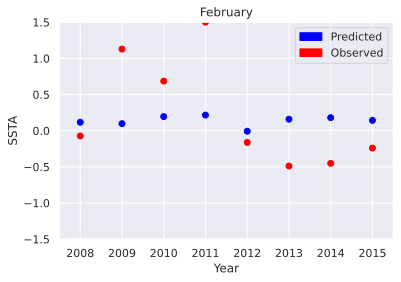

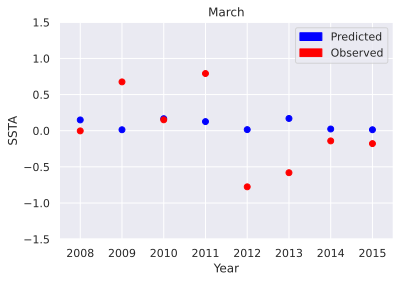

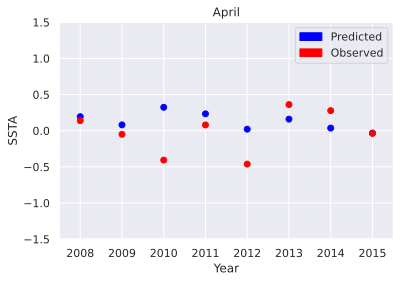

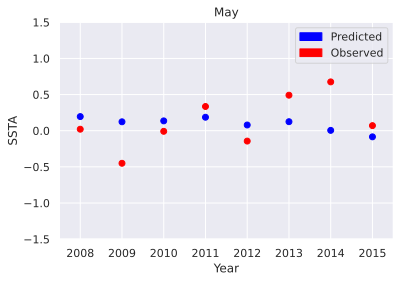

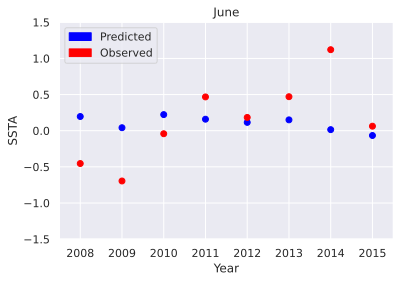

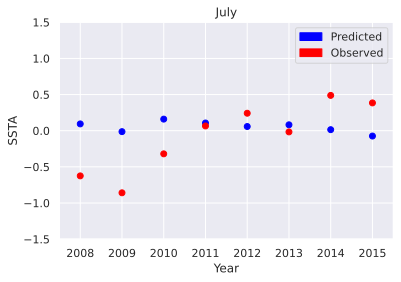

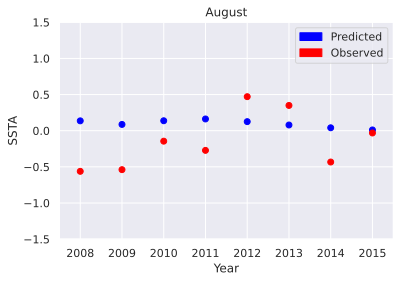

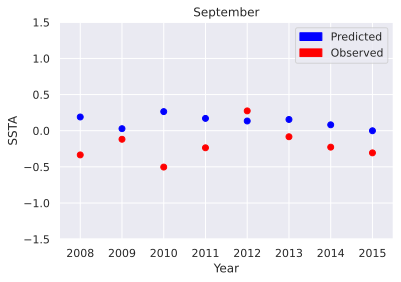

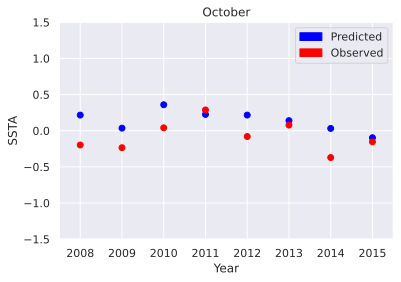

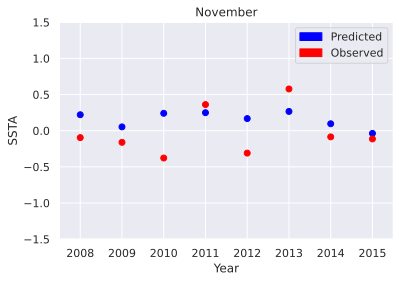

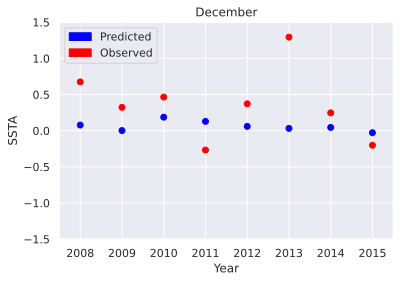

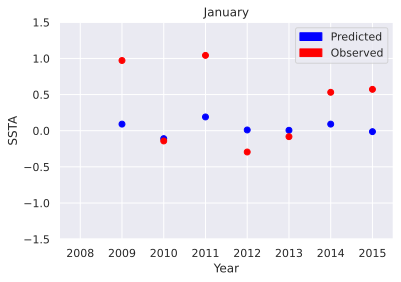

In [149]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import matplotlib.patches as mpatches

def plot_data(pred_y, real_y, month):
  
  month_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'January']
  year = [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
  year_1 = [2009, 2010, 2011, 2012, 2013, 2014, 2015]

  fig, ax = plt.subplots(figsize=(6, 4))

  ax.set_xlim([2007.5, 2015.5])
  ax.set_ylim([-1.5, 1.5])
  plt.xlabel('Year', fontsize=12)
  plt.ylabel('SSTA', fontsize=12)
  plt.title(month_list[month], fontsize=12)

  blue_patch = mpatches.Patch(color='blue', label='Predicted')
  red_patch = mpatches.Patch(color='red', label='Observed')
  ax.legend(handles=[blue_patch, red_patch])

  if len(pred_y) == 8:
    ax.plot(year, pred_y, 'o', color='blue')
    ax.plot(year, real_y, 'o', color='red')
  else:
    ax.plot(year_1, pred_y, 'o', color='blue')
    ax.plot(year_1, real_y, 'o', color='red')
  
  plt.savefig(month_list[month])
  """
  line = mlines.Line2D([0, 1], [0, 1], color='red')
  transform = ax.transAxes
  line.set_transform(transform)
  ax.add_line(line)
  """

for i in range(12):
  plot_data(pred_values_by_month[i], obs_values_by_month[i], i+1)

---------------

In [150]:
torch.__version__

'1.10.0+cu111'

In [151]:
!pip install torch torchvision
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 5.9 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 3.5 MB 8.5 MB/s 
     |████████████████████████████████| 370 kB 8.2 MB/s 
     |████████████████████████████████| 482 kB 51.2 MB/s 
     |████████████████████████████████| 41 kB 751 kB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.3-py3-none-any.whl size=581968 sha256=3ac1b9681b9121d3d8ac3266c6fc308753b338686b9df0e9f8aadc515207ed39
  Stored in directory: /root/.cache/pip/wheels/c3/2a/58/87ce0508964d4def1aafb92750c4f3ac77038efd1b9a89dcf5
Successfully built torch-geometric


In [152]:
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html

Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 2.3 MB 8.3 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 747 kB 6.9 MB/s 


In [153]:
import torch_geometric
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data
from torch_geometric.data import Data

In [154]:
gnn_layer_by_name = {
    "GCN": geom_nn.GCNConv,
    "GAT": geom_nn.GATConv,
    "GraphConv": geom_nn.GraphConv
}

In [155]:
lead_month = 1

label_vector = soda_sst_bop_anomaly[lead_month:]

feature_matrix_tensor = torch.from_numpy(feature_matrix[:,:-lead_month]).to(torch.float)
adjacency_matrix_tensor = torch.from_numpy(adjacency_matrix).to(torch.float)
label_vector_tensor = torch.from_numpy(label_vector).to(torch.float)

In [156]:
edges = torch.tensor(adjacency_matrix).nonzero(as_tuple=False).transpose(0,1)

edges.shape

torch.Size([2, 47941776])

In [157]:
data = Data(x=feature_matrix_tensor, edge_index=edges, num_nodes=feature_matrix.shape[0], y=label_vector_tensor)
data

Data(x=[6924, 431], edge_index=[2, 47941776], y=[431], num_nodes=6924)

In [158]:
data.num_node_features

431

In [159]:
DATASET_PATH = "../data"

cora_dataset = torch_geometric.datasets.Planetoid(root=DATASET_PATH, name="Cora")

cora_dataset[0]

Processing...
Done!


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [160]:
class GNNModel(nn.Module):

    def __init__(self, c_in, c_hidden, c_out, num_layers=2, layer_name="GCN", dp_rate=0.1, **kwargs):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of the output features. Usually number of classes in classification
            num_layers - Number of "hidden" graph layers
            layer_name - String of the graph layer to use
            dp_rate - Dropout rate to apply throughout the network
            kwargs - Additional arguments for the graph layer (e.g. number of heads for GAT)
        """
        super().__init__()
        gnn_layer = gnn_layer_by_name[layer_name]

        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers-1):
            layers += [
                gnn_layer(in_channels=in_channels,
                          out_channels=out_channels,
                          **kwargs),
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate)
            ]
            in_channels = c_hidden
        layers += [gnn_layer(in_channels=in_channels,
                             out_channels=c_out,
                             **kwargs)]
        self.layers = nn.ModuleList(layers)

    def forward(self, x, edge_index):
        """
        Inputs:
            x - Input features per node
            edge_index - List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
        """
        for l in self.layers:
            # For graph layers, we need to add the "edge_index" tensor as additional input
            # All PyTorch Geometric graph layer inherit the class "MessagePassing", hence
            # we can simply check the class type.
            if isinstance(l, geom_nn.MessagePassing):
                x = l(x, edge_index)
            else:
                x = l(x)
        return x

In [161]:
class NodeLevelGNN(pl.LightningModule):

    def __init__(self, model_name, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()

        if model_name == "MLP":
            self.model = MLPModel(**model_kwargs)
        else:
            self.model = GNNModel(**model_kwargs)
        self.loss_module = nn.MSELoss()

    def forward(self, data, mode="train"):
        x, edge_index = data.x, data.edge_index
        x = self.model(x, edge_index)

        """
        # Only calculate the loss on the nodes corresponding to the mask
        if mode == "train":
            mask = data.train_mask
        elif mode == "val":
            mask = data.val_mask
        elif mode == "test":
            mask = data.test_mask
        else:
            assert False, f"Unknown forward mode: {mode}"

        loss = self.loss_module(x[mask], data.y[mask])
        acc = (x[mask].argmax(dim=-1) == data.y[mask]).sum().float() / mask.sum()        
        """

        loss = self.loss_module(x, data.y)
        mse = self.loss_module(x, data.y)
        return loss, mse

    def configure_optimizers(self):
        # We use SGD here, but Adam works as well
        optimizer = optim.SGD(self.parameters(), lr=0.1, momentum=0.9, weight_decay=2e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="train")
        self.log('train_loss', loss)
        self.log('train_mse', mse)
        return loss

    """
    def validation_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="val")
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="test")
        self.log('test_acc', acc)
    """

In [162]:
def train_node_regressor(model_name, dataset, **model_kwargs):
    pl.seed_everything(42)
    node_data_loader = geom_data.DataLoader(dataset, batch_size=1)

    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "NodeLevel" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max")],
                         gpus=1 if str(device).startswith("cuda") else 0,
                         max_epochs=200,
                         progress_bar_refresh_rate=0) # 0 because epoch size is 1
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"NodeLevel{model_name}.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = NodeLevelGNN.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything()
        model = NodeLevelGNN(model_name=model_name, c_in=dataset.num_node_features, c_out=1, **model_kwargs)
        trainer.fit(model, node_data_loader, node_data_loader)
        model = NodeLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    """
    # Test best model on the test set
    test_result = trainer.test(model, test_dataloaders=node_data_loader, verbose=False)
    batch = next(iter(node_data_loader))
    batch = batch.to(model.device)
    _, train_acc = model.forward(batch, mode="train")
    _, val_acc = model.forward(batch, mode="val")
    result = {"train": train_acc,
              "val": val_acc,
              "test": test_result[0]['test_acc']}
    """
    _, train_mse = model.forward(batch, mode="train")
    result = {"train": train_mse}

    return model, result

In [163]:
def print_results(result_dict):
    """
    if "train" in result_dict:
        print(f"Train accuracy: {(100.0*result_dict['train']):4.2f}%")
    if "val" in result_dict:
        print(f"Val accuracy:   {(100.0*result_dict['val']):4.2f}%")
    print(f"Test accuracy:  {(100.0*result_dict['test']):4.2f}%")
    """

    print(f"Train MSE: {(100.0*result_dict['train']):4.2f}%")

In [164]:
CHECKPOINT_PATH = "../"

In [165]:
node_gnn_model, node_gnn_result = train_node_regressor(model_name="GNN",
                                                       layer_name="GCN",
                                                       dataset=data,
                                                       c_hidden=16,
                                                       num_layers=2,
                                                       dp_rate=0.1)
print_results(node_gnn_result)

Global seed set to 42
/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 42
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You p

KeyError: ignored

----------